In [1]:
%reset -f
%matplotlib inline

In [2]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import sebaba.ml as sbbml
import sebaba.utils as utils
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

from scipy.stats import norm
from missingpy import KNNImputer

In [3]:
pd.options.display.float_format = "{:.4f}".format

In [4]:
train_df = pd.read_csv("data/house-prices/train.csv", sep = ",")
train_df = train_df.drop("Id", axis = 1)
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_df = utils.drop_missing_var(train_df, threshold = 0.8)
utils.missing_var_pct(train_df)

FireplaceQu    47.2600
LotFrontage    17.7400
GarageCond      5.5500
GarageType      5.5500
GarageYrBlt     5.5500
GarageFinish    5.5500
GarageQual      5.5500
BsmtExposure    2.6000
BsmtFinType2    2.6000
BsmtFinType1    2.5300
BsmtCond        2.5300
BsmtQual        2.5300
MasVnrType      0.5500
MasVnrArea      0.5500
Electrical      0.0700
dtype: float64


In [6]:
#one hot encoding
#df = pd.get_dummies(df)
train_df["LogSalePrice"] = np.log(train_df.SalePrice)
train_df.drop("SalePrice", axis = 1, inplace = True)

In [7]:
num_train_df, cat_train_df = utils.split_numerical_categorical(train_df)
num_train_df.fillna(0, inplace = True)

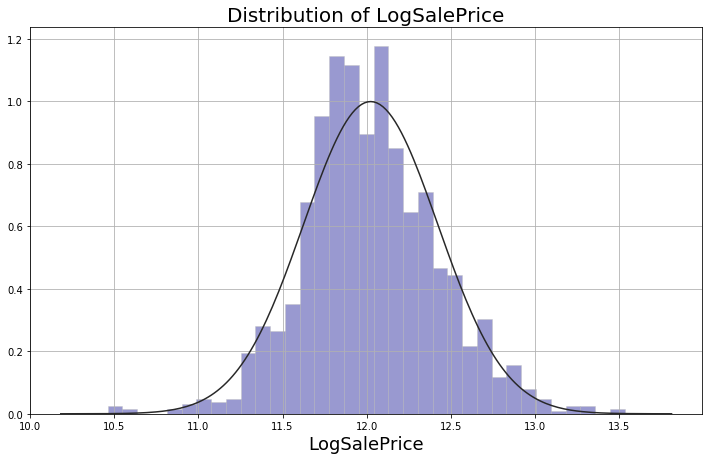

In [8]:
fig, ax = plt.subplots(figsize = (10.0, 6.5))
ax = sns.distplot(train_df.LogSalePrice, color = "darkblue", fit = norm, kde = False, hist_kws = {"edgecolor": "silver"})
ax.set_title("Distribution of LogSalePrice", fontsize = 20)
ax.set_xlabel("LogSalePrice", fontsize = 18)
ax.margins(0.05)
ax.axis("tight")
ax.grid(True)
fig.tight_layout()

plt.show()

In [9]:
corr = num_train_df.corr()

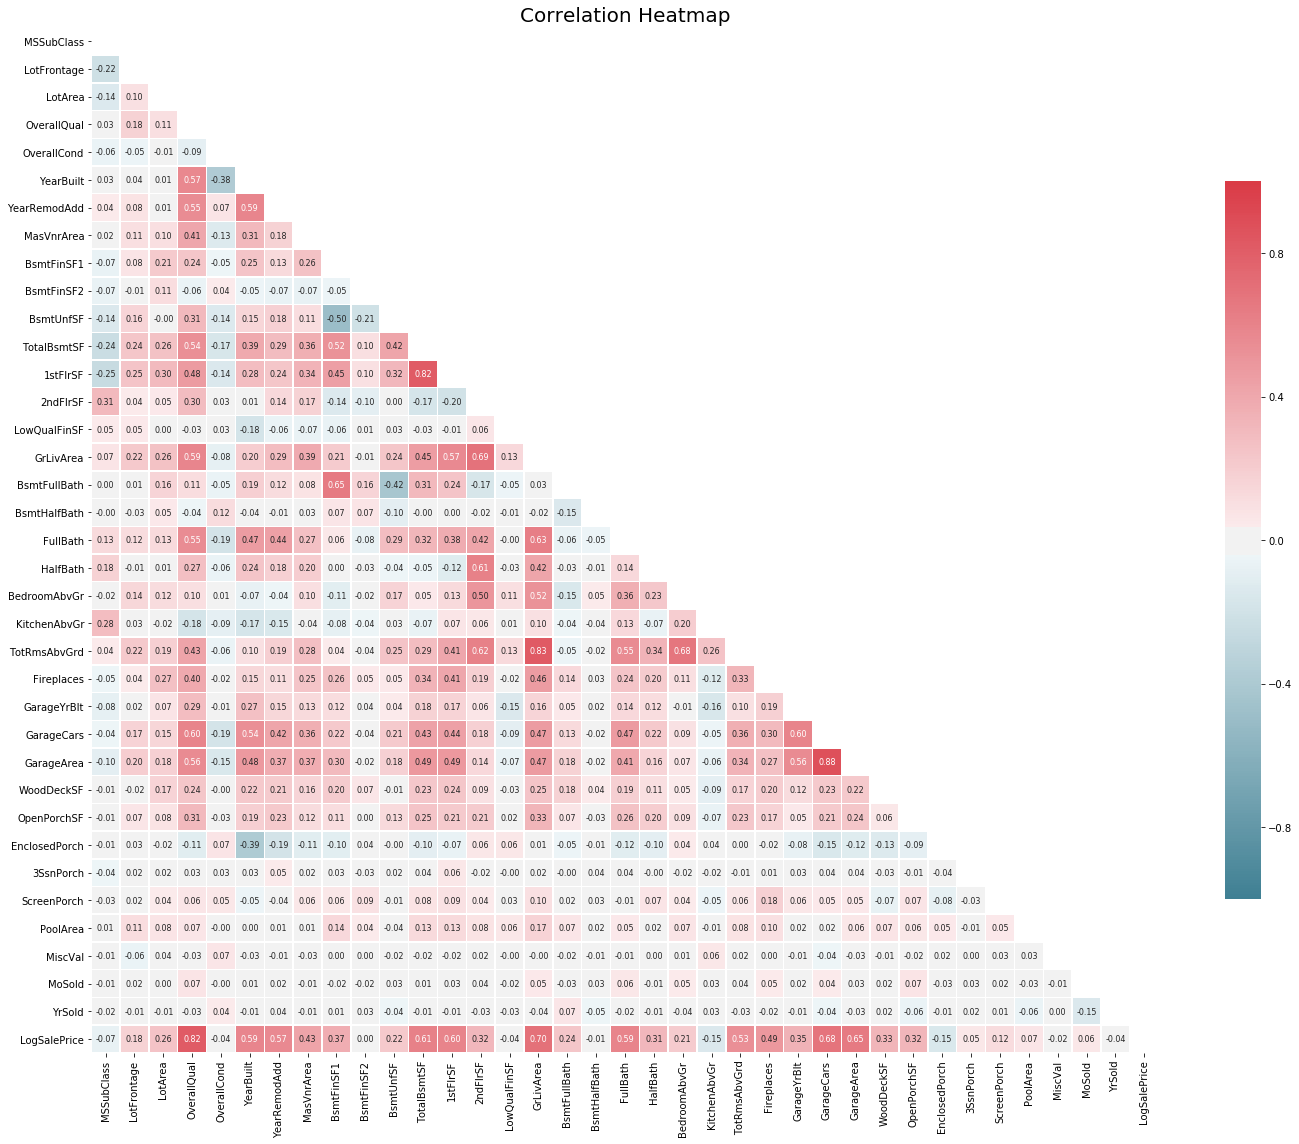

In [10]:
#generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap = True)

fig, ax = plt.subplots(figsize = (20, 16))
ax = sns.heatmap(corr, mask = mask, cmap = cmap, fmt = ".2f", vmin = -1, vmax = 1.0, center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": .7}, annot = True, annot_kws = {"size": 8})
ax.set_title("Correlation Heatmap", fontsize = 20)
ax.margins(0.05)
ax.axis("tight")
ax.grid(False)
fig.tight_layout()

plt.show()

In [11]:
in_matrix    = abs(corr.LogSalePrice) > 0.50
num_train_df = num_train_df.loc[ :,in_matrix.values]

In [12]:
y = num_train_df.LogSalePrice.values
x = num_train_df.drop("LogSalePrice", axis = 1).values

In [13]:
x_train, x_test, y_train, y_test = utils.split_train_test(x, y, prop_train = 80.0)

In [14]:
opt_lm   = None
min_rmse = np.inf

alpha_list = np.linspace(0, 10, num = 1000, dtype = float, endpoint = True)

for alpha in alpha_list:
    model = sbbml.LinearRegression(alpha, iterations = 100000, normalize = True)
    model.fit(x_train, y_train)

    y_prime = model.predict(x_test)
    rmse    = utils.root_mean_squared_error(y_prime, y_test)

    if rmse < min_rmse:
        print(f"rmse: {rmse: <20} \t alpha: {alpha}")
        min_rmse = rmse
        opt_lm   = model

rmse: 13.38870438244203    	 alpha: 0.0
rmse: 0.14589306605375713  	 alpha: 0.01001001001001001
rmse: 0.1458930574162691   	 alpha: 0.02002002002002002
rmse: 0.145893053258354    	 alpha: 0.03003003003003003
rmse: 0.14589305077435444  	 alpha: 0.04004004004004004
rmse: 0.14589304860820548  	 alpha: 0.050050050050050046
rmse: 0.14589304771144332  	 alpha: 0.06006006006006006
rmse: 0.1458930468558101   	 alpha: 0.07007007007007007
rmse: 0.1458930460214425   	 alpha: 0.08008008008008008
rmse: 0.1458930454683043   	 alpha: 0.09009009009009009
rmse: 0.14589304487135     	 alpha: 0.11011011011011011
rmse: 0.145893044080635    	 alpha: 0.12012012012012012
rmse: 0.1458930439729029   	 alpha: 0.13013013013013014
rmse: 0.14589304355405083  	 alpha: 0.14014014014014015
rmse: 0.1458930433256583   	 alpha: 0.15015015015015015
rmse: 0.14589304278028128  	 alpha: 0.16016016016016016
rmse: 0.14589304255900903  	 alpha: 0.18018018018018017
rmse: 0.1458930423534542   	 alpha: 0.19019019019019018
rmse: 0

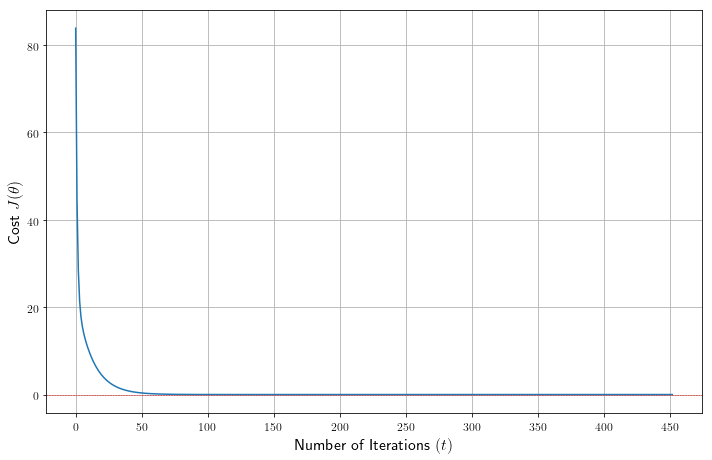

In [15]:
utils.plot_cost_function(cost = opt_lm.cost, width = 10.0, height = 6.5)

In [16]:
test_df    = pd.read_csv("data/house-prices/test.csv", na_values = "", sep = ",")
test_df_id = test_df.Id.values
test_df    = test_df.drop("Id", axis = 1)

In [17]:
test_df = test_df.loc[ :,num_train_df.columns]
test_df.drop("LogSalePrice", axis = 1, inplace = True)
utils.missing_var_pct(test_df)

GarageArea    0.0700
GarageCars    0.0700
TotalBsmtSF   0.0700
dtype: float64


In [18]:
num_test_df, cat_test_df = utils.split_numerical_categorical(test_df)
num_test_df.fillna(0, inplace = True)

In [19]:
num_test_x = num_test_df.values
y_prime    = opt_lm.predict(num_test_x)
y_prime    = np.exp(y_prime).flatten()

with open("data/house-prices/lr-submission.csv", mode = "w") as f:
    f.write("Id,SalePrice\n")
    for i in range(y_prime.shape[0]):
        f.write(f"{test_df_id[i]},{y_prime[i]}\n")

In [20]:
pca = sbbml.PCA(k = 2)
pca.fit(x)
x_reduced = pca.transform(x); x_reduced

array([[-1.22315107, -0.52561719],
       [-0.21907017, -0.18352442],
       [-1.09635421, -1.05637876],
       ...,
       [-0.80156162,  2.00058955],
       [ 1.99200873, -0.38793428],
       [ 1.63568493,  0.50381369]])